## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [13]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions
from leaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

In [5]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSSBSBB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
362
+------------------+------------------+------------------+---------+--------+--------+---------+-----------+------------------+-------------------+------------------+------------------+-----------+-----------+------+--------------------+------+
|           coeff_1|           coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|              res_2|             res_3|          res_mean|    station|  total_var|undefs|              vector|  year|
+------------------+------------------+------------------+---------+--------+--------+---------+-----------+------------------+-------------------+------------------+------------------+-----------+-----------+------+--------------------+------+
|1389.2409573309023| 67.23764973963051|-273.6827183050143|   2801.1|SSSSBSBB| 32.7904|-105.8204|       SNWD|0.2805995371466946|0.27678531228276415| 0.254408619259497|0.9622207218664723|US1NMO

In [29]:
#extract longitude and latitude for each station
# feature='coeff_1'
feature='coeff_1,coeff_2,coeff_3'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1,coeff_2,coeff_3 FROM weather
+-----------+--------+---------+---------+------------------+-------------------+-------------------+
|    station|latitude|longitude|elevation|           coeff_1|            coeff_2|            coeff_3|
+-----------+--------+---------+---------+------------------+-------------------+-------------------+
|US1NMOT0039| 32.7904|-105.8204|   2801.1|1389.2409573309023|  67.23764973963051| -273.6827183050143|
|USC00291927| 32.9667|  -105.75|   2688.6|2457.9016903816255| 1476.9900469816519| 224.27750939149152|
|USC00291931| 32.9544|-105.7353|   2645.4| 4603.571127108965|-1040.4605420453959|  608.1067998019532|
|US1NMOT0056| 32.9204| -105.747|   2658.8|  6948.58290639793| -1578.546383668709|-116.14816853415951|
+-----------+--------+---------+---------+------------------+-------------------+-------------------+
only showing top 4 rows



In [31]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", "coeff_1": "mean","coeff_2": "mean","coeff_3": "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_1),avg(coeff_2),avg(coeff_3)
26,US1NMDA0112,32.3956,-106.7824,1278.3,1,-1.341847,30.476711,25.416045
34,US1NMOT0039,32.7904,-105.8204,2801.1,5,350.278481,180.259139,4.964876


In [8]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#0094ff'

## Map

In [9]:
# min_lat,max_lat,min_long,max_long = box = (42.1103, 42.6167, -72.6, -70.8)
row = df.agg({"latitude": "min"}).collect()[0]
min_lat = row["min(latitude)"]

row = df.agg({"latitude": "max"}).collect()[0]
max_lat = row["max(latitude)"]

row = df.agg({"longitude": "min"}).collect()[0]
min_long = row["min(longitude)"]
row = df.agg({"longitude": "max"}).collect()[0]
max_long = row["max(longitude)"]

In [1]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

NameError: name 'min_lat' is not defined

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

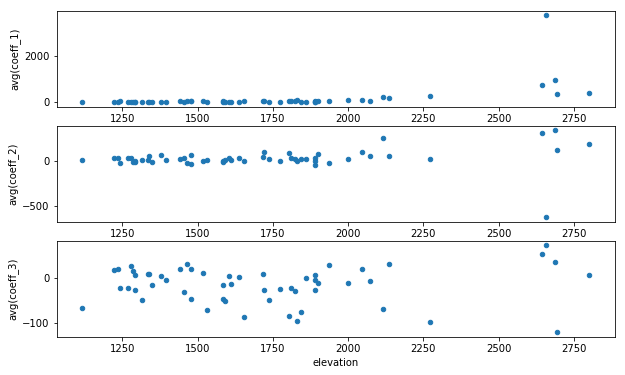

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=False,figsize=(10,6))
# pdf.plot.scatter(x='elevation',y='avg(coeff_3)');
pdf.plot(x='elevation',y='avg(coeff_1)', kind="scatter", ax=ax1)
pdf.plot(x='elevation',y='avg(coeff_2)', kind="scatter", ax=ax2)
pdf.plot(x='elevation',y='avg(coeff_3)', kind="scatter", ax=ax3)


In [21]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']